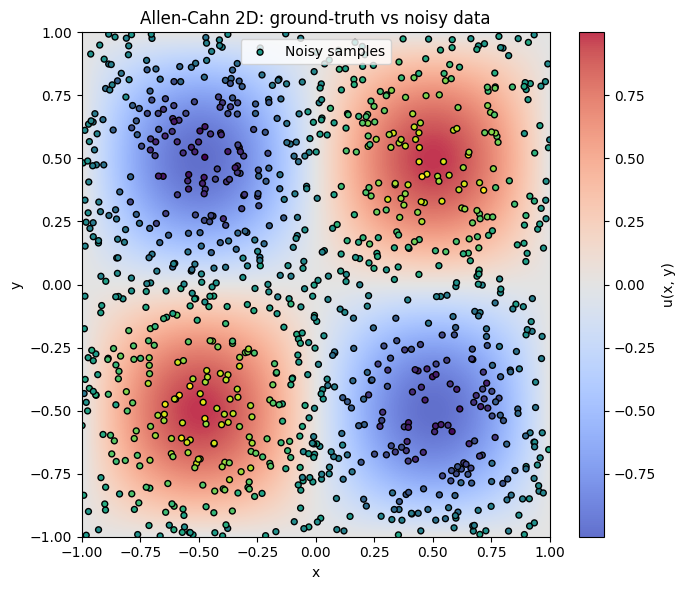

In [2]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn

torch.set_num_threads(5)
seed = 12345
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
x_colloc_num = 500  # Number of collocation points

data_noise = 0.1
N_train = 1000
N_test = 200
N_calib = 200
colloc_pt_num = 500

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)

alphas = torch.linspace(0.05, 0.99, 10)

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────
from utils_tools.utils_result_viz import plot_truth_and_samples_2D

# Dense grid for nice plotting
def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)


plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


In [ ]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random


# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_hmc import HMCBPINN

# CP
from utils_uqmd.utils_uq_cp import CP


# Model
hmc_model = HMCBPINN(
    pde_class=pde, input_dim=2, hidden_dims=[16, 32, 64, 64, 64, 32, 16],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

# Fitting args
fit_args = {
    "coloc_pt_num": colloc_pt_num,
    "X_train": X_train,
    "Y_train": Y_train
}
fit_kwargs_grid = {
    # "λ_pde": [1.0, 2.0, 5.0],
    # "λ_bc": [5.0, 10.0, 15.0],
    # "λ_data": [1.0, 2.0, 5.0],
    "λ_pde": [1.0],
    "λ_bc": [15.0],
    "λ_data": [3.0], 
    "epochs": [5000],
    "lr": [5e-4],
    "hmc_samples": [12000],
    "burn_in":[5000],
    "step_size": [7e-4],
    "leapfrog_steps": [10],
}


baseline_pred_kwargs = { "n_samples": 5000 }
cp_pred_kwargs = {
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 100
}
cp_coverage_args = {
    "alphas": alphas, "X_test": X_test, "Y_test": Y_test,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "X_train": X_train, "Y_train": Y_train,
    "heuristic_u": "raw_std", "k": 100
}
baseline_coverage_args = {
    # "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}


# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(domain[0][0],domain[0][1], n_grid)
y = torch.linspace(domain[1][0],domain[1][1], n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, hmc_test_uncertainties

hyperparameter_tuning(
    plot_title="HMC CP Model", # Change this
    # Model Fitting & Predicting
    uqmodel=hmc_model,  # Change this
    alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_testing_args=baseline_coverage_args, cp_testing_args=cp_coverage_args,
    baseline_test_uncertainties=hmc_test_uncertainties, # Change this
    # Plotting function
    plotting_func=plot_2D_comparison_with_coverage, # Chang if dimension changes
    save_dir="2dallencahn_hmc_cp", # Change this
    X_validation=X_test, Y_validation=Y_test,
)


[🔎] Trying: {'λ_pde': 1.0, 'λ_bc': 15.0, 'λ_data': 2.0, 'epochs': 4000, 'lr': 0.0005, 'hmc_samples': 12000, 'burn_in': 5000, 'step_size': 0.0009, 'leapfrog_steps': 10}

[🟠] Training...


MAP:  13%|█▎        | 506/4000 [00:11<01:18, 44.29it/s, loss=2.58e+00]

[MAP] epoch    500 −logPost=2.599e+00  Data=2.50e-01  PDE=5.02e-01  IC=0.00e+00  BC=1.03e-06


MAP:  25%|██▌       | 1009/4000 [00:21<01:07, 44.44it/s, loss=1.25e+00]

[MAP] epoch   1000 −logPost=1.260e+00  Data=2.50e-01  PDE=5.18e-01  IC=0.00e+00  BC=4.21e-05


MAP:  38%|███▊      | 1508/4000 [00:32<00:51, 48.45it/s, loss=8.76e-01]

[MAP] epoch   1500 −logPost=8.761e-01  Data=2.50e-01  PDE=5.12e-01  IC=0.00e+00  BC=5.70e-05


MAP:  50%|█████     | 2006/4000 [00:42<00:42, 46.89it/s, loss=7.73e-01]

[MAP] epoch   2000 −logPost=7.811e-01  Data=2.50e-01  PDE=5.13e-01  IC=0.00e+00  BC=2.36e-05


MAP:  63%|██████▎   | 2506/4000 [00:53<00:32, 46.46it/s, loss=7.76e-01]

[MAP] epoch   2500 −logPost=8.014e-01  Data=2.50e-01  PDE=5.46e-01  IC=0.00e+00  BC=3.25e-05


MAP:  75%|███████▌  | 3007/4000 [01:03<00:22, 43.58it/s, loss=7.64e-01]

[MAP] epoch   3000 −logPost=7.616e-01  Data=2.50e-01  PDE=5.10e-01  IC=0.00e+00  BC=3.33e-05


MAP:  88%|████████▊ | 3505/4000 [01:14<00:10, 48.09it/s, loss=7.79e-01]

[MAP] epoch   3500 −logPost=7.759e-01  Data=2.50e-01  PDE=5.26e-01  IC=0.00e+00  BC=2.60e-05


[MAP] epoch   4000 −logPost=7.785e-01  Data=2.50e-01  PDE=5.28e-01  IC=0.00e+00  BC=3.36e-05


KeyboardInterrupt: 